In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../data/cleaned_data.csv')
df.shape

(1259, 27)

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df = df.drop(columns=['date'])
df.head()

,close,volume,day,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,interest_rates,benz_rate,year,month,day_of_month
0,244.288,91222100.0,4.0,0.039,-0.012,0.051,-190.728,-260.374,-260.374,-205.515,-205.515,-370.093,-370.093,1.640,62.119,62.119,242.621,242.621,242.621,242.621,14.77,118.99,101.64,83.19,1.7,7.189,2018,5,4
1,245.114,55304900.0,0.0,0.127,0.029,0.097,-155.361,-225.370,-225.370,-212.133,-212.133,-251.843,-251.843,2.107,67.818,67.818,243.120,243.120,243.120,243.120,14.75,118.80,101.59,83.19,1.7,7.667,2018,5,7
2,245.114,67499200.0,1.0,0.177,0.069,0.108,-155.361,-202.033,-202.033,-208.767,-208.767,-188.567,-188.567,2.107,67.818,67.818,243.452,243.452,243.452,243.452,14.71,118.69,101.42,83.20,1.7,6.600,2018,5,8
3,247.483,59666100.0,2.0,0.313,0.131,0.182,-106.900,-170.322,-170.322,-195.952,-195.952,-119.063,-119.063,3.661,78.548,78.548,244.028,244.028,244.028,244.028,13.42,117.98,101.19,83.16,1.7,7.111,2018,5,9
4,249.797,72063900.0,3.0,0.510,0.222,0.288,-69.359,-136.668,-136.668,-176.191,-176.191,-57.623,-57.623,5.296,84.118,84.118,244.749,244.749,244.749,244.749,13.23,118.93,101.40,83.16,1.7,9.000,2018,5,10


In [7]:
target_column = 'close'

X = df.drop(target_column, axis=1).values
y = df[target_column].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split data into train, validation and test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [8]:
y_train.shape

(906,)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Adding a dummy sequence length dimension if it's not present
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[:, -1, :])
        return out

# Determine input size (number of features)
input_size = X.shape[1]

# Create model
model = LSTM(input_size=input_size, hidden_size=50, num_layers=2, output_size=1)

In [10]:
len(y_train)

906

In [11]:
# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):  # 100 epochs
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}')


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([906])) that is different to the input size (torch.Size([906, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([227])) that is different to the input size (torch.Size([227, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 120696.0, Validation Loss: 122243.5
Epoch: 2, Loss: 120689.984375, Validation Loss: 122237.46875
Epoch: 3, Loss: 120684.0234375, Validation Loss: 122231.40625
Epoch: 4, Loss: 120678.046875, Validation Loss: 122225.3203125
Epoch: 5, Loss: 120672.03125, Validation Loss: 122219.1328125
Epoch: 6, Loss: 120665.921875, Validation Loss: 122212.84375
Epoch: 7, Loss: 120659.6953125, Validation Loss: 122206.390625
Epoch: 8, Loss: 120653.328125, Validation Loss: 122199.734375
Epoch: 9, Loss: 120646.7421875, Validation Loss: 122192.8359375
Epoch: 10, Loss: 120639.9453125, Validation Loss: 122185.6796875
Epoch: 11, Loss: 120632.8671875, Validation Loss: 122178.1796875
Epoch: 12, Loss: 120625.46875, Validation Loss: 122170.3203125
Epoch: 13, Loss: 120617.7109375, Validation Loss: 122162.03125
Epoch: 14, Loss: 120609.546875, Validation Loss: 122153.2890625
Epoch: 15, Loss: 120600.9140625, Validation Loss: 122144.0
Epoch: 16, Loss: 120591.7734375, Validation Loss: 122134.140625
Epoch: 

In [12]:
# Convert test data to tensor
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Compute predictions on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

print(f'Test Loss: {test_loss.item()}')

Test Loss: 114726.1484375


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([126])) that is different to the input size (torch.Size([126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [13]:
# Predict on train and test data
model.eval()
with torch.no_grad():
    train_preds = model(X_train).numpy()
    test_preds = model(X_test).numpy()

In [14]:
# Create a DataFrame for the true and predicted values
df_train = pd.DataFrame({'True': y_train.numpy(), 'Predicted': np.squeeze(train_preds)}, index=range(len(y_train)))
df_test = pd.DataFrame({'True': y_test.numpy(), 'Predicted': np.squeeze(test_preds)}, index=range(len(y_train), len(y_train) + len(y_test)))

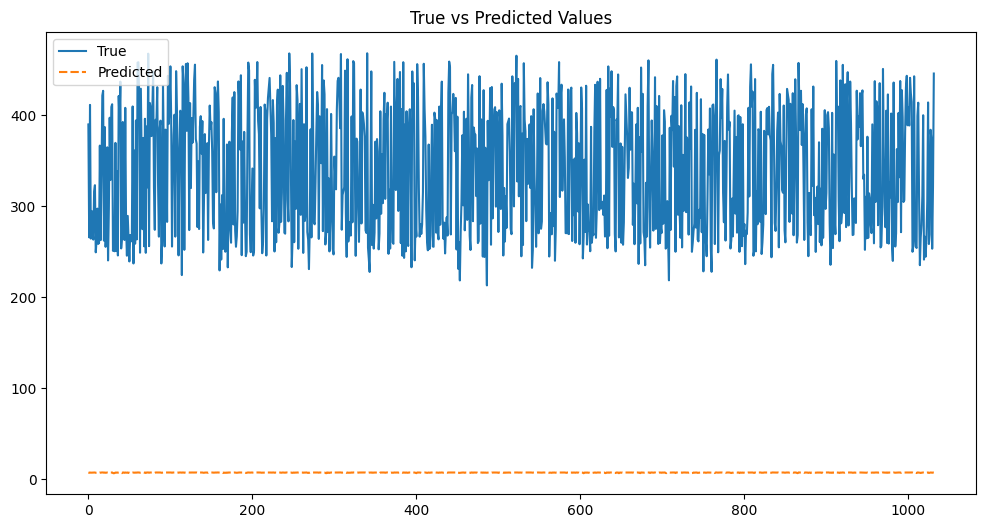

In [15]:
# Concatenate the train and test DataFrames along the index axis
df = pd.concat([df_train, df_test])

# Create a line plot of the true and predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(data=df)
plt.title('True vs Predicted Values')
plt.show()

In [16]:
df.head()

,True,Predicted
0,389.993988,7.149367
1,265.812012,6.834037
2,411.503998,7.143665
3,264.434998,6.952187
4,294.864990,6.995903
